# Vector Search with ColPali

## **TLDR:**

This is all the code you need to try ColPali:

### Installation

```bash
# If running locally
# For local, you will need to sign into the huggingface cli, request access to PaliGemma and have at least 8GB VRAM.
pip install 'midrasai[local]'

# If using the MidrasAI api
# For remote, you will need to get an api key from midrasai.com
pip install midrasai          
```

### Usage

```python
# If running locally
from midrasai.local import LocalMidras 
midras = LocalMidras()

# If using the API
from midrasai import Midras

midras = Midras(midras_key="your-key")
```
```python
# Everything else is the same!

index_name = "test_index"

midras.create_index(index_name)

response = midras.embed_pdf("Attention_is_all_you_need.pdf", include_images=True)

for id, embedding in enumerate(response.embeddings):
    midras.add_point(
        index=index_name,
        id=id,
        embedding=embedding,
        data={
            "page_number": id + 1,
            "anything_we_want": "Huzzah!"
        }
    )

query = "Explain the architechture diagram proposed in this paper"

results = midras.query_text(index_name, text=query)

print("Top 3 relevant pages, in order:")

for result in results[:3]:
    print(f"Page {result.data['page_number']} score: {result.score}")
```

### Running Locally

If you want to run the ColPali model that Midras uses, you'll need a GPU, I recommend at least a T4.

Also, you'll need to install some extra features from the midrasai package with the command:

```bash
pip install 'midrasai[local]'
```

This will download some additional dependencies such as Pytorch and Transformers needed to run the ColPali model locally.

By installing `midrasai[local]` you will get access to the "local" namespace in the midrasai package.
This namespace holds the LocalMidras class, which is identical to the standard Midras class, but loads and runs ColPali locally instead of remotely.

**NOTE:** You need to have permission to download the ColPali model from Huggingface. To do this, you'll have to follow these steps:

    1. Create a huggingface account

    2. Request access to ColPali

    3. Create an account token

    4. Authenticate from the cli with `huggingface-cli login`
    

In [1]:
from midrasai.local import LocalMidras

midras = LocalMidras()

/home/anibal/p/midrasai/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anibal/p/midrasai/.venv/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-

Now that the model is loaded, we can create an index to start saving data!
We can use the "embed_pdf" method to input the *path* to a pdf file locally, which will then be turned into a list of images and embeddings.

In [2]:
# Define any name for our index
index_name = "test_index" 

# Create a new index using our index name
midras.create_index(index_name)

True

Now we have our index, but it's empty.

Let's use the *embed_pdf* utility method to process a pdf file which we will then load into our index.

The *embed_pdf* method accepts a path to a local pdf file and returns a response object with the ColBERT vector embeddings for each page in the pdf.

Additionaly, if we set the parameter "include_images" to True, the response object will also return the list of PIL Images that were generated from the pdf.

**NOTE:** The *embed_pdf* method relies on poppler to convert pdfs to images. If it fails, make sure you have poppler installed on your system. 

In [3]:
# Pass the path to a pdf file to embed_pdf, set include_images to True to receive the images generated from the pdf (one per page)
response = midras.embed_pdf("./Attention_is_all_you_need.pdf", include_images=True)

print(f"Number of pages: {len(response.images)}")

Number of pages: 15


Let's visualize the first page...

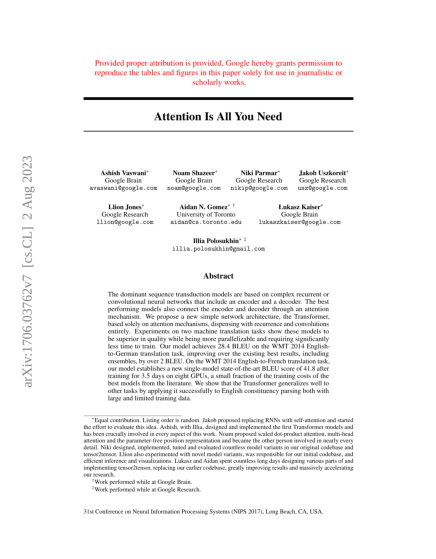

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(response.images[0])
plt.axis("off")
plt.show()

Now we have our embeddings, so we can use them to store data in our vector database along with any important information.

Let's write a for loop that goes through every image, and calls the *add_point* method to create a list of entries with an id, a vector which will be use for search, and a payload which can be any information you want to attach to this vector. In this payload we are adding a field called "page_number" that is equal to the index of that page plus one. This is because indeces in python start at 0, so page 1 will have an index of 0, page 2 is index 1, and so on.

In [5]:
# For every page in the pdf, let's add a data point to our index.
for i in range(len(response.images)):
    midras.add_point(
        index=index_name,
        id=i,
        embedding=response.embeddings[i],
        data={
            "page_number": i + 1,
            "anything_else_we_want": "Huzzah!"
        }
    )

Finally, with our index loaded with data points, we can use the *query_text* method to run similarity search on the index with a text input.

Top 3 relevant pages, in order:
Page 8 score: 15.09604256559654


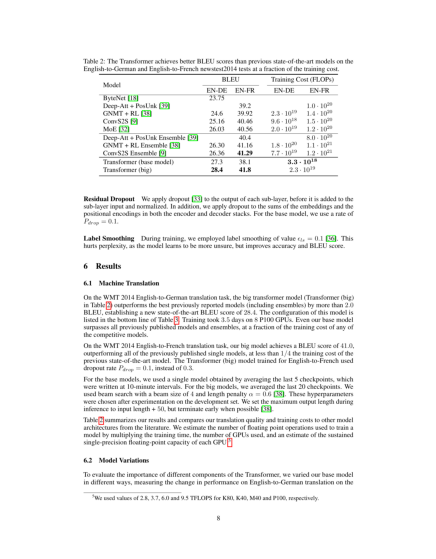

Page 9 score: 14.873562842883446


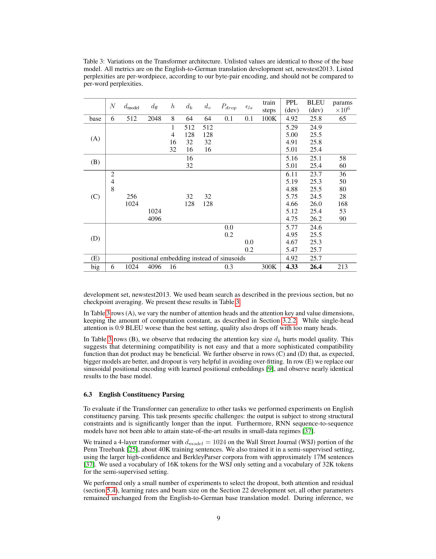

Page 10 score: 12.858036854055388


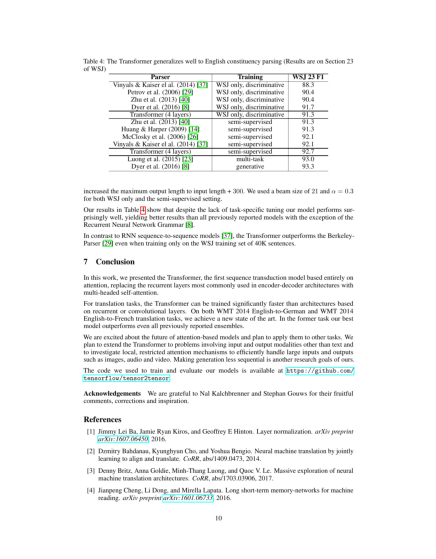

In [6]:
query = "What is the BLEU score of transformers?"

results = midras.query_text(index_name, text=query)

print("Top 3 relevant pages, in order:")

for result in results[:3]:
    print(f"Page {result.data['page_number']} score: {result.score}")

    plt.figure(figsize=(7,7))
    plt.imshow(response.images[result.id])
    plt.axis("off")
    plt.show()

As a last step, we can pass the results to a multimodal to any multimodal LLM to generate a response to our query.

In this example I will use Gemini Flash from `google-generativeai`.

In [7]:
import os
import google.generativeai as genai

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

model = genai.GenerativeModel("gemini-1.5-flash")

image = response.images[results[0].id] # Pass the image from the top result to Gemini
question = "What is the BLEU score of transformers?" # Pass the original question to Gemini

response = model.generate_content([image, question])
print(response.text)

The transformer achieves a BLEU score of 41.8 on the English-to-French translation task.



### Using the API

If you don't have the hardware to try ColPali locally, you can go to [midrasai](https://midrasai.com) and generate an api key with your Github account.
This key will give you access to a ColPali model on I'm running on some cloud GPUs.

Once you have your key, you can use it to create a Midras client.
Since it's not running locally, you can just install it with `pip install midrasai` and avoid heavy libraries like pytorch!

In [8]:
from midrasai import Midras
import os

midras = Midras(os.getenv("MIDRAS_API_KEY"))

After you create your client with the Midras API, the rest of the code is exactly the same!

In [9]:
# Define any name for our index
index_name = "test_index" 

# Create a new index using our index name
midras.create_index(index_name)

True

In [10]:
# Pass the path to a pdf file to embed_pdf, set include_images to True to receive the images generated from the pdf (one per page)
response = midras.embed_pdf("./Attention_is_all_you_need.pdf", include_images=True)

print(f"Number of pages: {len(response.images)}")

Number of pages: 15


In [11]:
# For every page in the pdf, let's add a data point to our index.
for i in range(len(response.images)):
    midras.add_point(
        index=index_name,
        id=i,
        embedding=response.embeddings[i],
        data={
            "page_number": i + 1,
            "anything_else_we_want": "Huzzah!"
        }
    )

Top 3 relevant pages, in order:
Page 3 score: 14.54778957244845


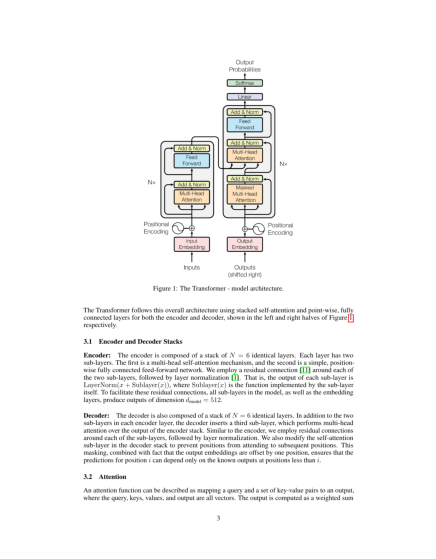

Page 2 score: 14.43880959831948


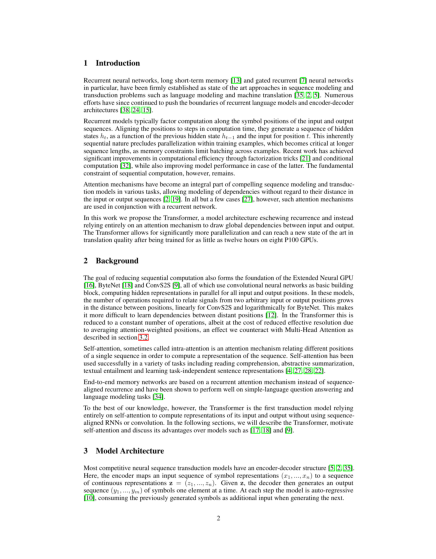

Page 1 score: 14.232025199570314


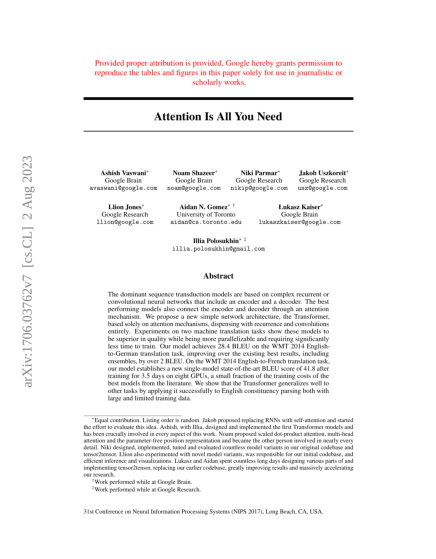

In [12]:
query = "Explain the transformers model architecture proposed in this paper"

results = midras.query_text(index_name, text=query)

print("Top 3 relevant pages, in order:")

for result in results[:3]:
    print(f"Page {result.data['page_number']} score: {result.score}")

    plt.figure(figsize=(7,7))
    plt.imshow(response.images[result.id])
    plt.axis("off")
    plt.show()

Now let's ask Gemini to use the results to give us an anwser to our question.

In [13]:
# Create a list with the images from the top 3 results
contents = [response.images[result.id] for result in results[:3]]
contents.append(query)

response = model.generate_content(contents)
print(response.text)

The Transformer model architecture is based on the idea of self-attention. Instead of relying on sequential computation, the Transformer uses a mechanism to calculate the relationships between all words in a sentence at once. This allows the model to learn long-range dependencies in a sentence, which is not possible with traditional recurrent neural networks.

The Transformer consists of two main parts: an encoder and a decoder. The encoder takes a sequence of words as input and encodes it into a representation that captures the meaning of the sentence. The decoder then takes this representation as input and generates a sequence of words as output.

The encoder and decoder are both composed of stacked layers. Each layer consists of two sub-layers: a multi-head self-attention mechanism and a feed-forward neural network. The multi-head self-attention mechanism allows the model to learn different aspects of the sentence and combine them into a single representation. The feed-forward neura